There are a few data files that need downloading to run this notebook.  

Download supplementary data table 2 from Martincorena, Fowler et al.    
http://science.sciencemag.org/content/362/6417/911  
Place in the same directory as this notebook.   
The file should be named "aau3879_TableS2.xlsx" and contains the oeosphagus clone size data.  
This is required for all plots.

To plot the incomplete moment for non-expressed and synonymous mutations (Figure 6c), download the human protein atlas rna_tissue data and unzip in the same directory as this notebook.  
https://www.proteinatlas.org/about/download

To plot the scatter plot of nonsense dN/dS ratio vs median clone size (Figure 6d), download supplementary data table 3 from Martincorena, Fowler et al.    
http://science.sciencemag.org/content/362/6417/911  
Place in the same directory as this notebook.   
The file should be named "aau3879_TableS3.xlsx" and contains the dndscv analysis for the oesophagus data.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams.update({'font.size': 22})

# Functions

In [2]:
def get_estimated_clone_size_unmerged(row):
    # Assumes non-synonymous NOTCH1 mutations are accompanied by a copy neutral LOH event.
    # Assumes any mutations in chromosomes 1-22 are heterozygous.
    # No mutations in Y chromosome.
    # Multiplying by the extra 2 due to the 2mm2 biopsies
    if (row['gene'] == 'NOTCH1' and row['impact'] != 'Synonymous') or (row['chr'] == 'X'):
        return row['vaf']*2
    else:
        return 2*row['vaf']*2
    
def get_estimated_clone_size_merged(row):
    # Assumes non-synonymous NOTCH1 mutations are accompanied by a copy neutral LOH event.
    # Assumes any mutations in chromosomes 1-22 are heterozygous.
    # No mutations in Y chromosome.
    # Multiplying by the extra 2 due to the 2mm2 biopsies
    if (row['gene'] == 'NOTCH1' and row['impact'] != 'Synonymous') or (row['chr'] == 'X'):
        return row['sumvaf']*2
    else:
        return 2*row['sumvaf']*2

In [3]:
def incomplete_moment_vaf_fixed_intervals(vafs, interval, fit_prop):
    vafs = np.flip(np.sort(vafs), axis=0)
    mean_clone_size = vafs.mean()
    fit_count = len(vafs)*(1-fit_prop)

    x = np.arange(int(vafs.min() / interval) * interval, round(vafs.max() / interval) * interval,
                  interval)

    if len(x) == 0:
        print('Failed for intervals', flush=True)
        print(int(vafs.min() / interval) * interval, round(vafs.max() / interval) * interval,
                  interval)

    x_idx = -1
    last_x = x[x_idx]
    y = []
    incom = 0
    fit_num = None
    for i, v in enumerate(vafs):
        while v < last_x:
            y.append(incom)
            x_idx -= 1
            last_x = x[x_idx]
        incom += v
        if i >= fit_count and fit_num is None:
            fit_num = len(y)
    y.append(incom)
    
    fit_num = len(y) - fit_num

    return x, np.flip(np.array(y), axis=0) / mean_clone_size / len(vafs), fit_num

In [4]:
def rsq_calc(x, y):
    if len(y) > 1:
        x_min = x.min()
        log_incom = np.log(y)
        B = np.vstack([x]).T - x_min
        slope, resids = np.linalg.lstsq(B, log_incom)[0:2]
        one_intercept = 0  # =log(1)
        rsq = 1 - resids[0] / (len(log_incom) * log_incom.var())
    else:
        print('Only 1 clone size')
        rsq = np.nan

    return rsq

In [5]:
def fit_straight_line(x, y, fit_num, fix_intercept=True):
    log_incom = np.log(y[:fit_num])
    x = x[:fit_num]
    if fix_intercept:  # Fix the intercept to (min_clone_size, 1)
        B = np.vstack([x]).T
        slope, resids = np.linalg.lstsq(B, log_incom)[0:2]
        one_intercept = 0  # =log(1)
        r_squared_value = 1 - resids[0] / (len(log_incom) * log_incom.var())
    else:  # No fixed intercept at all
        slope, one_intercept, r_value, p_value, std_err = linregress(x, log_incom)
        r_squared_value = r_value ** 2
    return slope, one_intercept, r_squared_value

In [6]:
def plot_for_donor(merged_data, donor, unmerged_data=None, interval=0.02, fit_prop=0.75, fit_line=False, show_legend=True):
    x1, y1, fit_num = incomplete_moment_vaf_fixed_intervals(merged_data[merged_data['donor'] == donor]['estimated_clone_size'], 
                                                            interval, fit_prop)
    r1 = rsq_calc(x1, y1)
    plt.plot(x1, y1, 'r', label='merged: r$^2$={0:.2f}'.format(r1))
    
    if fit_line:
        slope, one_intercept, _ = fit_straight_line(x1, y1, fit_num)
        y_fit = np.exp(slope * (
            x1 - x1[0]) + one_intercept)  # Take exp because was fit to the log.
    
    if unmerged_data is not None:
        x2, y2, fit_num = incomplete_moment_vaf_fixed_intervals(unmerged_data[unmerged_data['donor'] == donor]['estimated_clone_size'], 
                                                                interval, fit_prop)
        r2 = rsq_calc(x2, y2)
        plt.plot(x2, y2, 'b', label='unmerged: r$^2$={0:.2f}'.format(r2))
        
    plt.yscale('log')
    
    if fit_line:
        # Get axes limits before plotting fit line
        ylim = plt.gca().get_ylim()
        plt.plot(x1, y_fit, 'r--', dashes=(10, 10))
        plt.ylim(ylim)
    
    plt.xlabel('Clone Size (mm$^2$)')
    plt.ylabel('First Incomplete Moment')
    if show_legend:
        plt.legend()
    plt.xlim(left=0)
    plt.tight_layout()

# Data

In [7]:
# Loads the oesophagus clone size data

In [8]:
unmerged_data = pd.read_excel('aau3879_TableS2.xlsx', 
                              'All_mutations', skiprows=16)

In [9]:
merged_data = pd.read_excel('aau3879_TableS2.xlsx', 
                            'Mutations_collapsed_by_distance', skiprows=17)

In [10]:
merged_data['estimated_clone_size'] = merged_data.apply(get_estimated_clone_size_merged, axis=1)
unmerged_data['estimated_clone_size'] = unmerged_data.apply(get_estimated_clone_size_unmerged, axis=1)

In [11]:
unmerged_data['donor'] = unmerged_data.apply(lambda x: x['sampleID'][:7], axis=1)

# Merged and unmerged clone size plots

PD36806
total mutations 266


/Users/mh28/miniconda3/envs/competition/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


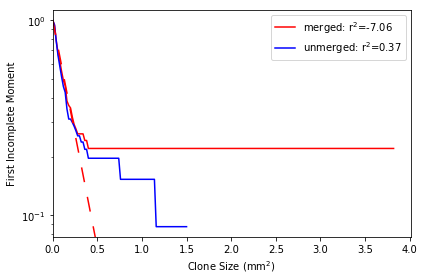

PD36712
total mutations 414


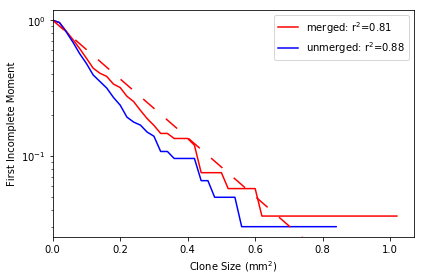

PD30272
total mutations 400


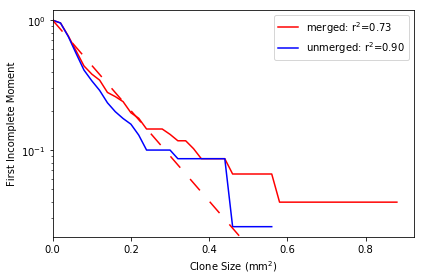

PD30986
total mutations 1070


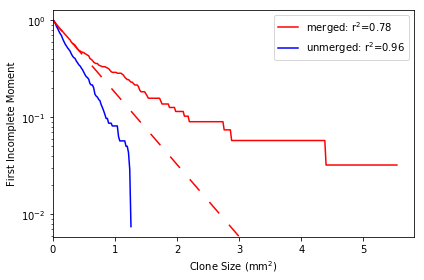

PD30987
total mutations 791


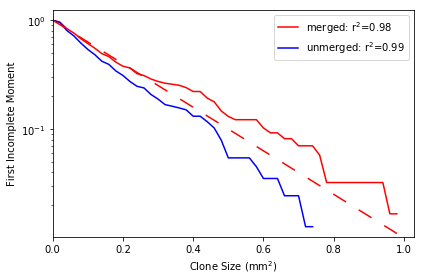

PD30274
total mutations 613


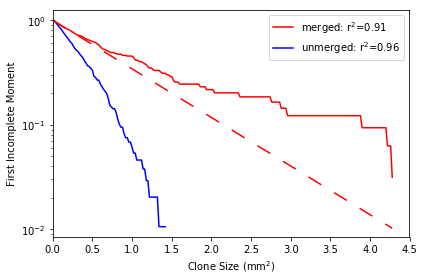

PD30988
total mutations 1222


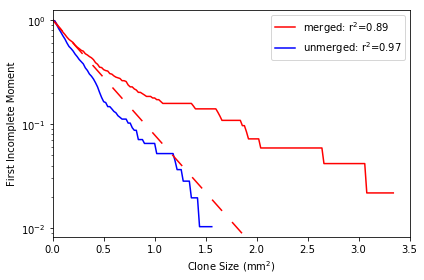

PD30273
total mutations 1120


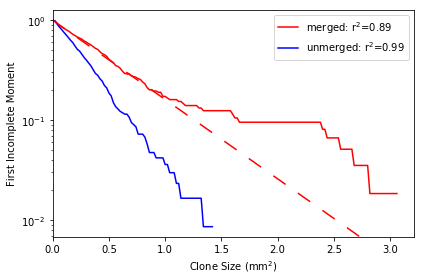

PD31182
total mutations 1039


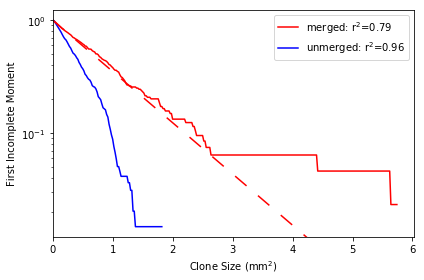

In [12]:
for donor in merged_data['donor'].unique():
    print(donor)
    print('total mutations', len(merged_data[merged_data['donor']==donor]))
    plot_for_donor(merged_data=merged_data, donor=donor, unmerged_data=unmerged_data, 
                                          fit_line=True, fit_prop=0.75, show_legend=True)
    plt.show()

# Non-expressed genes and synonymous mutations

In [13]:
# RNAseq data for normal tissue downloaded from the human protein atlas. https://www.proteinatlas.org/about/download  
# Accessed 01/10/2018 (Downloaded file dated 1 dec 2017)
hpa = pd.read_csv("rna_tissue.tsv", sep='\t')

In [14]:
# Only look at the data from the oesophagus
oe_hpa = hpa[hpa['Sample'] == 'esophagus']

In [15]:
# The selected genes from the dnds analysis
selected_genes = ['TP53', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'FAT1', 'ARID1A', 'AJUBA',
                  'CUL3', 'CCND1', 'PIK3CA', 'KMT2D', 'TP63', 'NFE2L2', 'ARID2',
                  'KMT2A', 'IRF6']
oe_hpa[oe_hpa['Gene name'].isin(selected_genes)]

,Gene,Gene name,Sample,Value,Unit
19362,ENSG00000036257,CUL3,esophagus,60.1,TPM
45040,ENSG00000073282,TP63,esophagus,60.9,TPM
46076,ENSG00000074181,NOTCH3,esophagus,45.3,TPM
59322,ENSG00000083857,FAT1,esophagus,14.9,TPM
137355,ENSG00000110092,CCND1,esophagus,78.9,TPM
166030,ENSG00000116044,NFE2L2,esophagus,267.1,TPM
173689,ENSG00000117595,IRF6,esophagus,63.7,TPM
174392,ENSG00000117713,ARID1A,esophagus,19.7,TPM
175132,ENSG00000118058,KMT2A,esophagus,6.3,TPM
190783,ENSG00000121879,PIK3CA,esophagus,7.3,TPM


In [16]:
non_expressed_genes = set(oe_hpa[oe_hpa['Value'] == 0]['Gene name'])

In [17]:
sequenced_genes = set(merged_data['gene'].unique())

In [18]:
non_expressed_sequenced_genes = non_expressed_genes.intersection(sequenced_genes)
non_expressed_sequenced_genes

{'ADAM29', 'GRM3', 'KCNH5', 'MUC17', 'PTPRT', 'SCN11A', 'SCN1A', 'SPHKAP'}

In [19]:
# Select only clones we assume to not be under selection, i.e. synonymous mutations and mutations in non-expressed genes
non_selected_data = merged_data[(merged_data['gene'].isin(non_expressed_sequenced_genes)) | (merged_data['impact'] == 'Synonymous')]

In [20]:
# Remove mutations at a synonymous site in TP53 that is known to affect splicing
t125t_muts = (non_selected_data['gene'] == 'TP53') & (non_selected_data['aachange'] == 'T125T')
non_selected_data = non_selected_data[~t125t_muts]

/Users/mh28/miniconda3/envs/competition/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


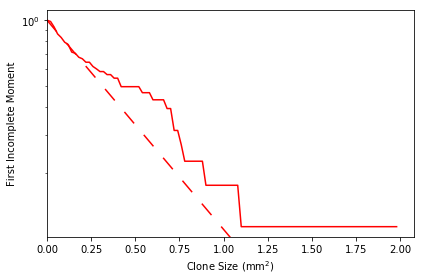

In [21]:
# Plot for the oldest donor
donor = "PD31182"
plot_for_donor(non_selected_data, donor, fit_line=True, fit_prop=0.75, show_legend=False)

# Scatter plot - nonsense dN/dS ratio vs clone size

In [22]:
# Load the dN/dS analysis
dnds_results = pd.read_excel("aau3879_TableS3.xlsx", skiprows=3)

In [23]:
merged_median_vals = {}

nonsense_mutations = merged_data[merged_data['impact'] == 'Nonsense']
for gene, gene_df in nonsense_mutations.groupby('gene'):
    merged_median_vals[gene] = gene_df['sumvaf'].median()
        
synonymous_median = merged_data[merged_data['impact'] == 'Synonymous']['sumvaf'].median()

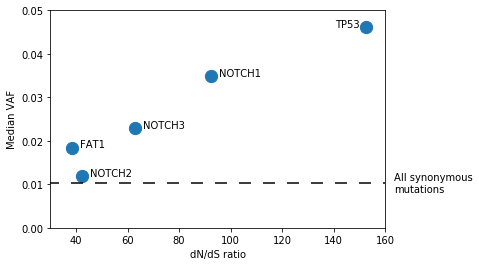

In [24]:
gene_list = list(dnds_results[:5]['gene_name'])
w = 'wnon_cv'
p = plt.scatter(dnds_results[:5][w], [merged_median_vals[gene] for gene in gene_list], s=150)
plt.plot([0, 160], [synonymous_median, synonymous_median], 
         'k--',  dashes=(8, 8), label='All\nSynonymous')
plt.xlim([30, 160])
plt.ylim([0, 0.05])
for i, g in enumerate(gene_list):
    if g == 'TP53':
        a = -12
    else:
        a = 3
    plt.annotate(g, (dnds_results.iloc[i][w]+a, merged_median_vals[g]))
    
plt.gcf().text(0.92, 0.25, 'All synonymous\nmutations')

plt.ylabel('Median VAF');
plt.xlabel('dN/dS ratio');